In [2]:

# from keras.models import Sequential

# model = Sequential()


ImportError: No module named keras.models

In [ ]:
import sys


In [1]:
# -*- coding: utf-8 -*-

from __future__ import print_function
from __future__ import absolute_import

import numpy as np
from keras import backend as K
from keras.layers import Input, Dense
from keras.models import Model
from keras.layers import Dense, Dropout, Reshape, Permute
from keras.layers.convolutional import Convolution2D, Conv2D
from keras.layers.convolutional import MaxPooling2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import ELU
from keras.layers.recurrent import GRU
from keras.utils.data_utils import get_file
from keras.utils.layer_utils import convert_all_kernels_in_model

TH_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.3/music_tagger_crnn_weights_tf_kernels_th_dim_ordering.h5'
TF_WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.3/music_tagger_crnn_weights_tf_kernels_tf_dim_ordering.h5'


def librosa_exists():
    try:
        __import__('librosa')
    except ImportError:
        return False
    else:
        return True


def preprocess_input(audio_path, dim_ordering='default'):
    '''Reads an audio file and outputs a Mel-spectrogram.
    '''
    if dim_ordering == 'default':
        dim_ordering = K.image_dim_ordering()
    assert dim_ordering in {'tf', 'th'}

    if librosa_exists():
        import librosa
    else:
        raise RuntimeError('Librosa is required to process audio files.\n' +
                           'Install it via `pip install librosa` \nor visit ' +
                           'http://librosa.github.io/librosa/ for details.')

    # mel-spectrogram parameters
    SR = 12000
    N_FFT = 512
    N_MELS = 96
    HOP_LEN = 256

    src, sr = librosa.load(audio_path, sr=SR)
    n_sample = src.shape[0]

    logam = librosa.logamplitude
    melgram = librosa.feature.melspectrogram
    x = logam(melgram(y=src, sr=SR, hop_length=HOP_LEN,
                      n_fft=N_FFT, n_mels=N_MELS) ** 2,
              ref_power=1.0)

    if dim_ordering == 'th':
        x = np.expand_dims(x, axis=0)
    elif dim_ordering == 'tf':
        x = np.expand_dims(x, axis=3)
    return x

def MusicTaggerCRNN(weights='msd', input_tensor=None,
                    include_top=True):
    '''Instantiate the MusicTaggerCRNN architecture,
    optionally loading weights pre-trained
    on Million Song Dataset. Note that when using TensorFlow,
    for best performance you should set
    `image_dim_ordering="tf"` in your Keras config
    at ~/.keras/keras.json.

    The model and the weights are compatible with both
    TensorFlow and Theano. The dimension ordering
    convention used by the model is the one
    specified in your Keras config file.

    For preparing mel-spectrogram input, see
    `audio_conv_utils.py` in [applications](https://github.com/fchollet/keras/tree/master/keras/applications).
    You will need to install [Librosa](http://librosa.github.io/librosa/)
    to use it.

    # Arguments
        weights: one of `None` (random initialization)
            or "msd" (pre-training on ImageNet).
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        include_top: whether to include the 1 fully-connected
            layer (output layer) at the top of the network.
            If False, the network outputs 32-dim features.


    # Returns
        A Keras model instance.
    '''
    if weights not in {'msd', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `msd` '
                         '(pre-training on Million Song Dataset).')

    # Determine proper input shape
    if K.image_dim_ordering() == 'th':
        input_shape = (1, 96, 1366)
    else:
        input_shape = (96, 1366, 1)

    if input_tensor is None:
        melgram_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            melgram_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            melgram_input = input_tensor

    # Determine input axis
    if K.image_dim_ordering() == 'th':
        channel_axis = 1
        freq_axis = 2
        time_axis = 3
    else:
        channel_axis = 3
        freq_axis = 1
        time_axis = 2

    # Input block
    x = ZeroPadding2D(padding=(0, 37))(melgram_input)
    x = BatchNormalization(axis=time_axis, name='bn_0_freq')(x)

    # Conv block 1
    x = Conv2D(64, (3, 3), padding='same', name='conv1')(x)
    x = BatchNormalization(axis=channel_axis, mode=0, name='bn1')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1')(x)

    # Conv block 2
    x = Conv2D(128, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(axis=channel_axis, mode=0, name='bn2')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(3, 3), name='pool2')(x)

    # Conv block 3
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(axis=channel_axis, mode=0, name='bn3')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), name='pool3')(x)

    # Conv block 4
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(axis=channel_axis, mode=0, name='bn4')(x)
    x = ELU()(x)
    x = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), name='pool4')(x)

    # reshaping
    if K.image_dim_ordering() == 'th':
        x = Permute((3, 1, 2))(x)
    x = Reshape((15, 128))(x)

    # GRU block 1, 2, output
    x = GRU(32, return_sequences=True, name='gru1')(x)
    x = GRU(32, return_sequences=False, name='gru2')(x)

    if include_top:
        x = Dense(50, activation='sigmoid', name='output')(x)

    # Create model
    model = Model(melgram_input, x)
    if weights is None:
        return model
    else:
        # Load weights
        if K.image_dim_ordering() == 'tf':
            weights_path = get_file('music_tagger_crnn_weights_tf_kernels_tf_dim_ordering.h5',
                                    TF_WEIGHTS_PATH,
                                    cache_subdir='models')
        else:
            weights_path = get_file('music_tagger_crnn_weights_tf_kernels_th_dim_ordering.h5',
                                    TH_WEIGHTS_PATH,
                                    cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
        if K.backend() == 'theano':
            convert_all_kernels_in_model(model)
        return model


ImportError: No module named keras

In [34]:
#model = MusicTaggerCRNN(weights='msd')

audio_path = '/Users/Chen/百度云同步盘/Startup/Clevo/润华数据/voice2/20170711/207/341432_207_104024.wav'
melgram = preprocess_input(audio_path)
melgrams = np.expand_dims(melgram, axis=0)

#preds = model.predict(melgrams)

In [35]:
librosa.get_duration(melgram.squeeze(), sr=12000)

0.3814166666666667

In [15]:
import librosa.display
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rc
%matplotlib inline
plt.style.use("ggplot")

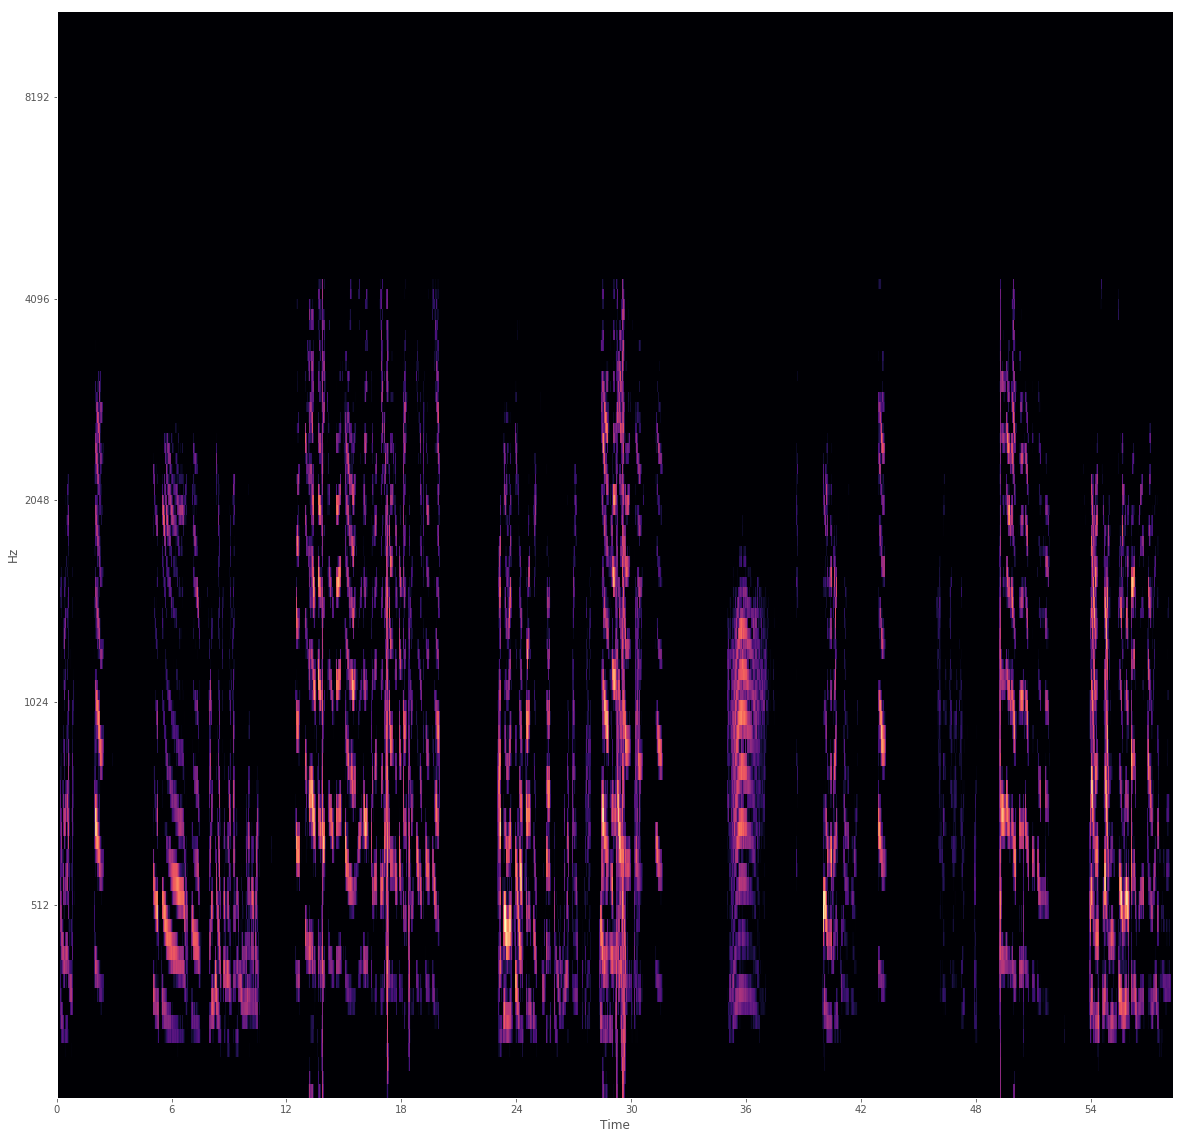

In [24]:
plt.figure(figsize=(20,20))
librosa.display.specshow(melgram.squeeze(), sr=12000, x_axis='time', y_axis='mel')
#plt.imshow(melgram.squeeze(), origin='lower')
plt.show()